# Classification: Predicting Distance based on RSSI measurements

This notebook is part of the bachelor thesis. The goal is to train and evaluate models that predict the distance based on RSSI data. The [dataset](https://github.com/samuelfrnk/BA_Samuel/blob/main/Experiments/Results/Data_CSV/Combined_Data/combined_data.csv) in use was collected using 11 Airtags that emitted BLE packets alongside RSSI values at various distances. Several models are being looked at. Moreover the benefit of smoothening RSSI values, additional features is being looked at to ultimately find the best model for the task.   




## Table of Contents




- [1. Data Import and Exploration](#1-data-import-and-exploration)
- [2. Data Preprocessing](#2-data-preprocessing)
- [3. Feature Selection/Importance](#3-feature-selectionimportance)
- [4. Bucketing for Classification](#4-bucketing-for-classification)
- [5. Model Training](#5-model-training)
- [6. Model Evaluation](#6-model-evaluation)
- [7. Visualization of Results](#7-visualization-of-results)
- [8. Baseline Comparisation](#7-visualization-of-results)



## 1. Data Import and Exploration

In this section we will import necessary libraries, import the dataset and perform an initial highlevel exploration to better understand the data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, r2_score, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE



df = pd.read_csv('combined_data.csv')


df.head()


,RSSI-Value,MAC-Address,Timestamp,Distance,indoor,LOS
0,-19,F0:79:C0:40:FB:93,2024-09-12 09:45:00,0.0,1,1
1,-18,EA:25:00:4F:3C:4D,2024-09-12 09:45:00,0.0,1,1
2,-21,EF:0D:1E:F2:0C:B2,2024-09-12 09:45:01,0.0,1,1
3,-19,CB:08:AA:AA:C9:C6,2024-09-12 09:45:01,0.0,1,1
4,-19,ED:4F:A6:06:39:7A,2024-09-12 09:45:01,0.0,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13353 entries, 0 to 13352
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RSSI-Value   13353 non-null  int64  
 1   MAC-Address  13353 non-null  object 
 2   Timestamp    13353 non-null  object 
 3   Distance     13353 non-null  float64
 4   indoor       13353 non-null  int64  
 5   LOS          13353 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 626.0+ KB


In [ ]:
df.describe()

,RSSI-Value,Distance,indoor,LOS
count,13353.000000,13353.000000,13353.000000,13353.000000
mean,-66.492099,1.092324,0.522280,0.492099
std,13.458537,0.561952,0.499522,0.499956
min,-94.000000,0.000000,0.000000,0.000000
25%,-77.000000,0.600000,0.000000,0.000000
50%,-66.000000,1.100000,1.000000,0.000000
75%,-59.000000,1.600000,1.000000,1.000000
max,-17.000000,2.000000,1.000000,1.000000


In [ ]:
df.isnull().sum()

,0
RSSI-Value,0
MAC-Address,0
Timestamp,0
Distance,0
indoor,0
LOS,0


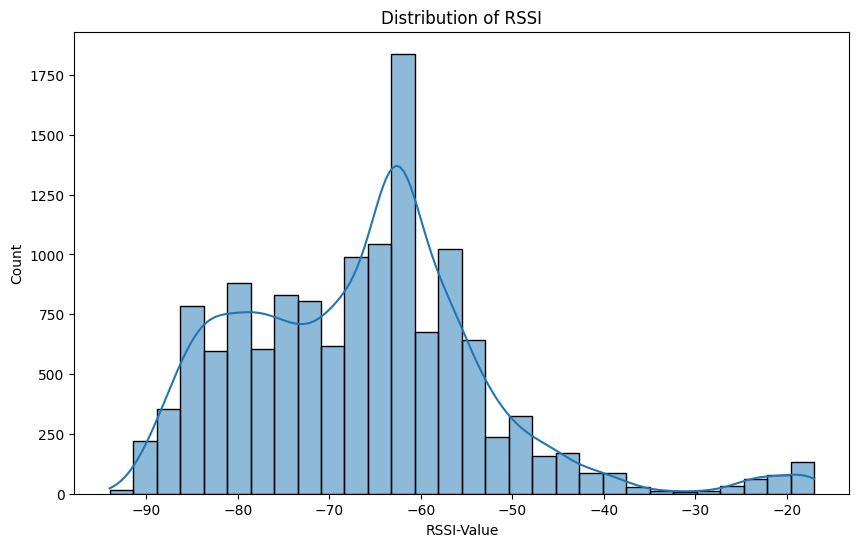

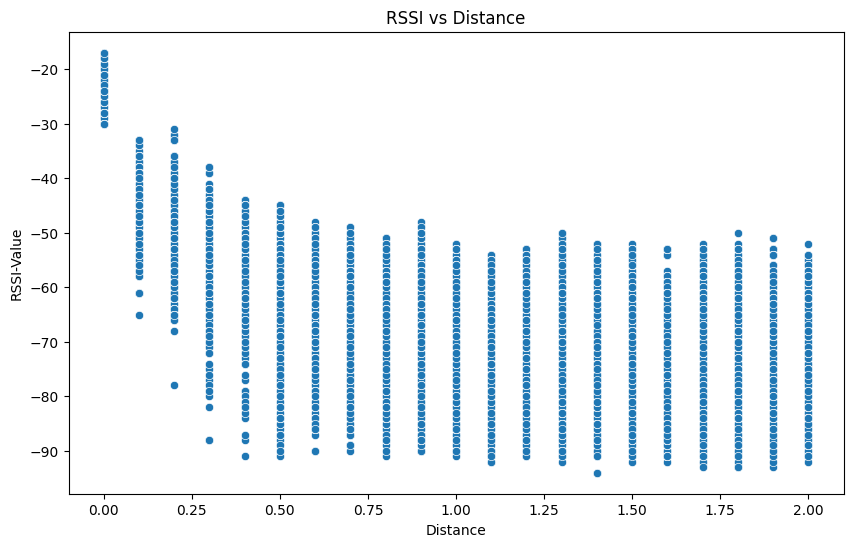

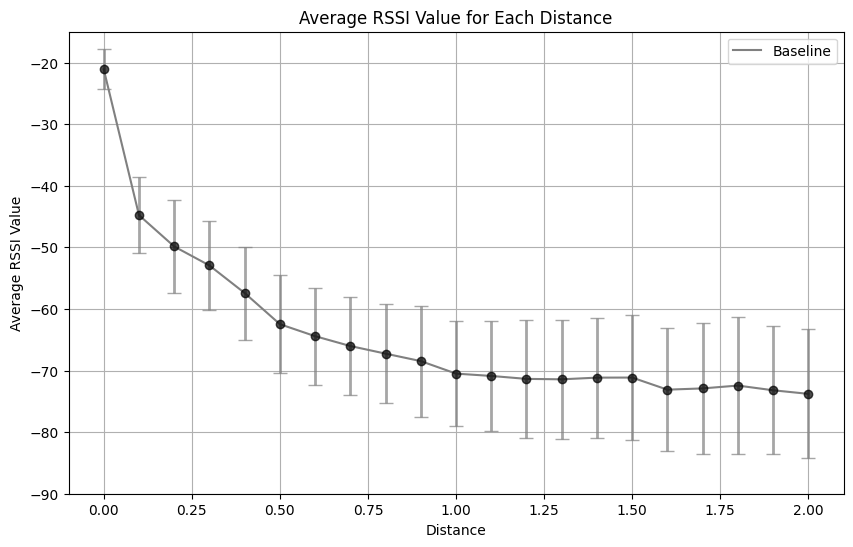

In [ ]:
#This provides overview plots of the data
plt.figure(figsize=(10,6))
sns.histplot(df['RSSI-Value'], bins=30, kde=True)
plt.title('Distribution of RSSI')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='Distance', y='RSSI-Value', data=df)
plt.title('RSSI vs Distance')
plt.show()

rssi_stats = df.groupby('Distance')['RSSI-Value'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(10, 6))

plt.errorbar(
    rssi_stats['Distance'],
    rssi_stats['mean'],
    yerr=rssi_stats['std'],
    fmt='o',
    capsize=5,
    color='black',
    ecolor='gray',
    elinewidth=2,
    alpha=0.7
)

plt.plot(rssi_stats['Distance'], rssi_stats['mean'], linestyle='-', color='grey', label='Baseline')

plt.xlabel('Distance')
plt.ylabel('Average RSSI Value')
plt.title('Average RSSI Value for Each Distance')

plt.ylim(-90, -15)

plt.grid(True)
plt.legend()

plt.show()

## 2. Data Preprocessing



In order to avoid biases and reduce the probability of overfitting all entries within one distance class are shuffled.

In [ ]:
df = df.groupby("Distance", group_keys=False).apply(lambda group: group.sample(frac=1)).reset_index(drop=True)
df.head()

<ipython-input-6-ca5577c07b70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Distance", group_keys=False).apply(lambda group: group.sample(frac=1)).reset_index(drop=True)


,RSSI-Value,MAC-Address,Timestamp,Distance,indoor,LOS
0,-21,CA:6B:21:3F:49:82,2024-10-30 14:14:59,0.0,0,1
1,-25,E2:BB:32:6A:FC:01,2024-09-12 09:45:43,0.0,1,1
2,-25,DE:E7:A8:C4:50:E7,2024-09-12 09:45:51,0.0,1,1
3,-22,EF:0D:1E:F2:0C:B2,2024-09-12 09:45:33,0.0,1,1
4,-25,F2:C7:6C:15:14:53,2024-10-30 14:14:23,0.0,0,1


As we want to investigate the influence of RSSI smoothening on the models performance we will add a column containing the smoothend RSSI values. A moving averaging filter is used with a window size of 5.

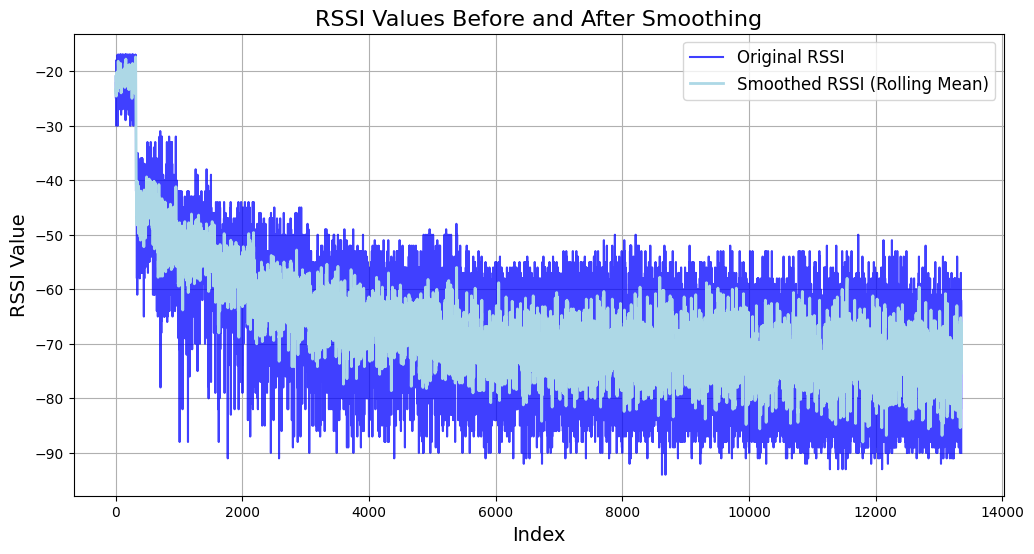

In [ ]:
df['RSSI-Smoothed'] = df['RSSI-Value'].rolling(window=5, min_periods=1).mean()
# Visualize the effect of smoothing
plt.figure(figsize=(12, 6))
plt.plot(df['RSSI-Value'], label='Original RSSI', alpha=0.75, color='blue')

plt.plot(df['RSSI-Smoothed'], label='Smoothed RSSI (Rolling Mean)', color='lightblue', linewidth=2)

plt.title('RSSI Values Before and After Smoothing', fontsize=16)
plt.xlabel('Index', fontsize=14)
plt.ylabel('RSSI Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()



## 3. Feature Selection/Importance Analysis

This section makes insights about the importance of features. A first set of models (Random Forest, Decision Tree, KNN and SVM) are trained. Afterwards the feature importance is being plotted for both the Random Forest model and the Decision Tree model. In the case of KNN and SVM the Permutation feature Importance is being calculated and plotted.

### Random Forest Classifier

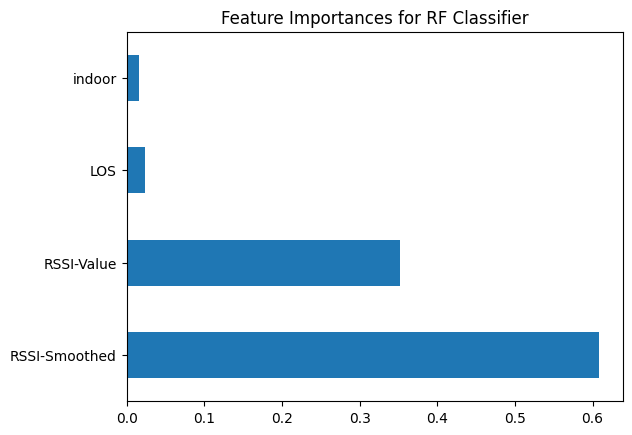

In [ ]:
df_copy = df.copy()
df_copy['Distance_Class'] = df_copy['Distance'].astype(str)
X = df_copy[['RSSI-Value', 'RSSI-Smoothed', 'indoor', 'LOS']]
y = df_copy['Distance_Class']
model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

feat_importances.nlargest(5).plot(kind='barh')
plt.title('Feature Importances for RF Classifier')
plt.show()


### Decision Tree Classifier



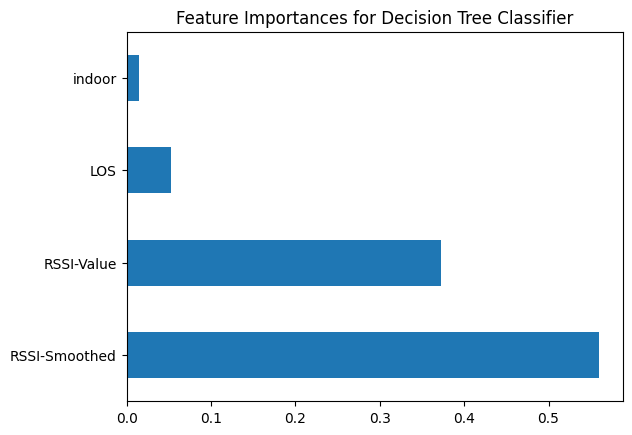

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X, y)
dt_importances = dt_model.feature_importances_
dt_feat_importances = pd.Series(dt_importances, index=X.columns)
dt_feat_importances.nlargest(5).plot(kind='barh')
plt.title('Feature Importances for Decision Tree Classifier')
plt.show()

### KNN


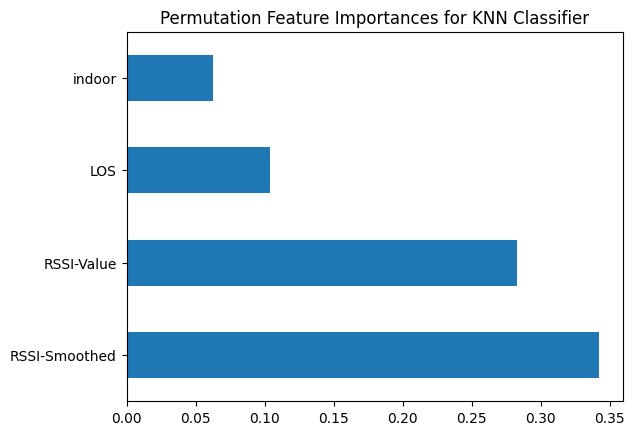

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X, y)
knn_importances = permutation_importance(knn_model, X, y, n_repeats=10, random_state=42)
knn_feat_importances = pd.Series(knn_importances.importances_mean, index=X.columns)
knn_feat_importances.nlargest(5).plot(kind='barh')
plt.title('Permutation Feature Importances for KNN Classifier')
plt.show()

### SVM

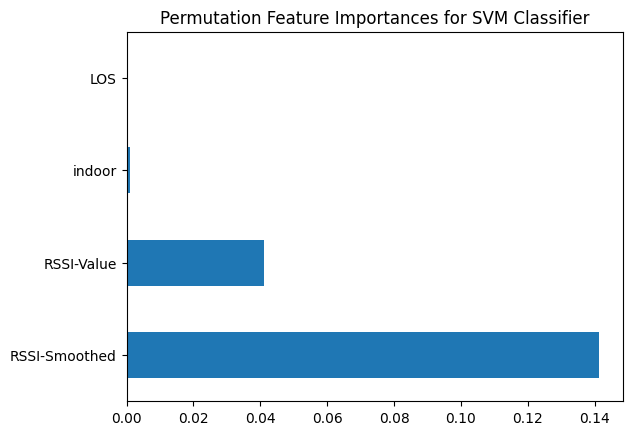

In [ ]:
svm_model = SVC()
svm_model.fit(X, y)
svm_importances = permutation_importance(svm_model, X, y, n_repeats=3, random_state=42)
svm_feat_importances = pd.Series(svm_importances.importances_mean, index=X.columns)
svm_feat_importances.nlargest(5).plot(kind='barh')
plt.title('Permutation Feature Importances for SVM Classifier')
plt.show()

As we can see in all considered models the smoothend RSSI values tend to be the most important feature for classification.

## 4. Bucketing for classification


The bucketing into binary classes is being made.

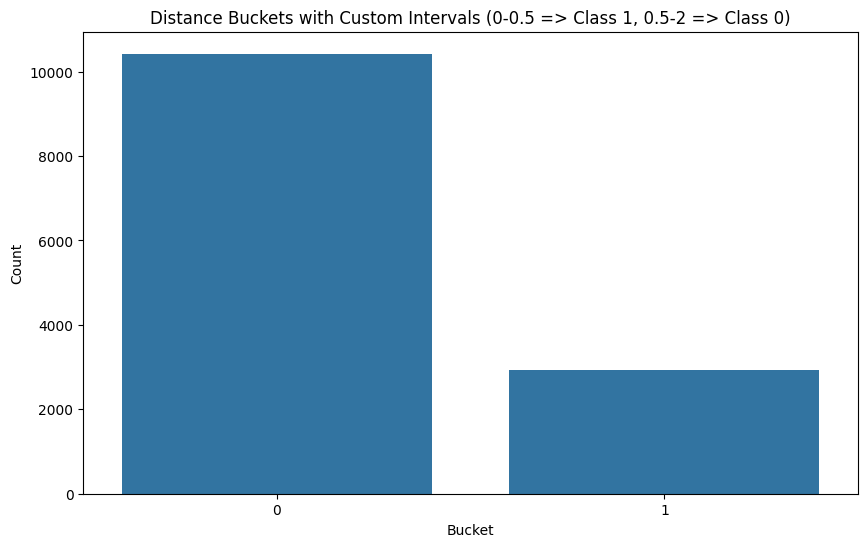

Bucket 0: Count = 10424, Distance Range = (0.5, 2.0]
Bucket 1: Count = 2929, Distance Range = (-0.001, 0.5]


In [ ]:
bins = [0, 0.5, 2.0]

cut_result = pd.cut(df['Distance'], bins=bins, include_lowest=True, right=True)

df['distance_bucket_custom'] = cut_result.cat.codes

df['distance_bucket_custom'] = df['distance_bucket_custom'].max() - df['distance_bucket_custom']

bin_intervals = cut_result.cat.categories

plt.figure(figsize=(10, 6))
sns.countplot(x='distance_bucket_custom', data=df)
plt.title('Distance Buckets with Custom Intervals (0-0.5 => Class 1, 0.5-2 => Class 0)')
plt.xlabel('Bucket')
plt.ylabel('Count')
plt.show()

bucket_counts = df['distance_bucket_custom'].value_counts().sort_index()

for i, (count, dist_range) in enumerate(zip(bucket_counts, bin_intervals[::-1])):
    print(f"Bucket {i}: Count = {count}, Distance Range = {dist_range}")




## 5. Model Training

We'll split the data into training and testing sets, train different models.

Split the data into training and testing data. In order to avoid imbalanced classes SMOTE is used for the upcoming classification models.

In [ ]:
X_clf = df[['RSSI-Value', 'indoor', 'LOS']]
y_clf = df['distance_bucket_custom']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)
smote = SMOTE(random_state=42)
X_train_clf_resampled, y_train_clf_resampled = smote.fit_resample(X_train_clf_scaled, y_train_clf)


## 6. Model Evaluation

In order to evaluate the best performing model the custom performance score is being computed this includes the weighted normalized metrics (cros-val accuracy, F1, train_accuracy - test_accuracy normalized)


Decision Tree Training Accuracy: 0.8595
Decision Tree Test Accuracy: 0.8858
Decision Tree F1 Score (Test): 0.8882
Decision Tree Mean Cross-validation Accuracy: 0.8535 (+/- 0.0103)
Decision Tree Cross-validation Accuracy Scores: [0.84613077 0.85178518 0.85508551 0.8619862  0.85268527]
Decision Tree Normalized Accuracy Difference: 0.0297
Decision Tree Performance Score: 0.8412

Classification Report for Decision Tree on Test Data:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2091
           1       0.71      0.80      0.75       580

    accuracy                           0.89      2671
   macro avg       0.83      0.86      0.84      2671
weighted avg       0.89      0.89      0.89      2671



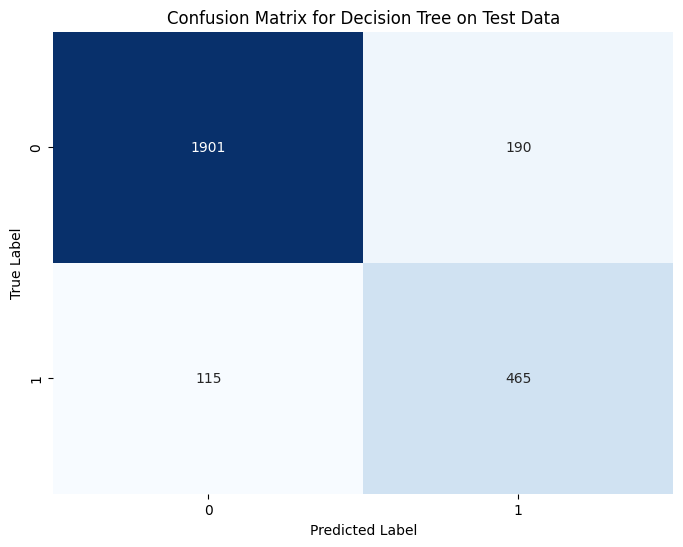

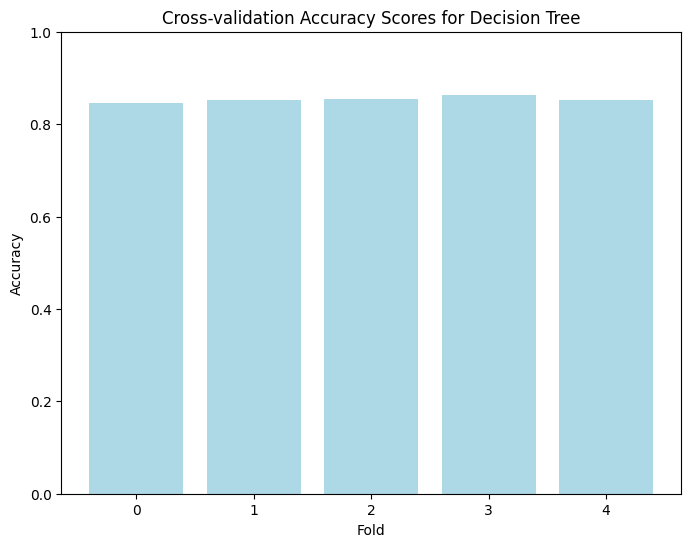

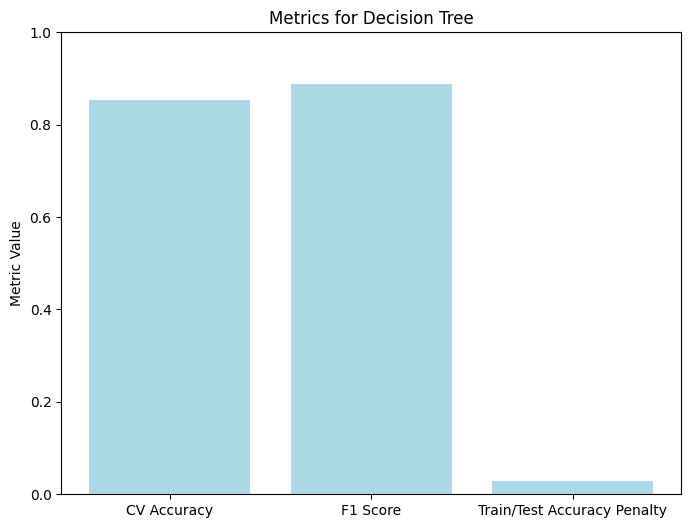


Random Forest Training Accuracy: 0.8595
Random Forest Test Accuracy: 0.8858
Random Forest F1 Score (Test): 0.8882
Random Forest Mean Cross-validation Accuracy: 0.8531 (+/- 0.0107)
Random Forest Cross-validation Accuracy Scores: [0.84613077 0.849985   0.85508551 0.8619862  0.85208521]
Random Forest Normalized Accuracy Difference: 0.0297
Random Forest Performance Score: 0.8409

Classification Report for Random Forest on Test Data:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2091
           1       0.71      0.80      0.75       580

    accuracy                           0.89      2671
   macro avg       0.83      0.86      0.84      2671
weighted avg       0.89      0.89      0.89      2671



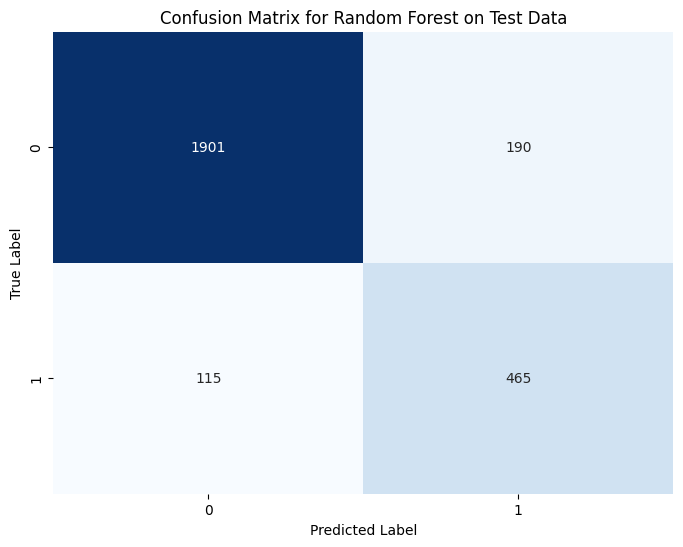

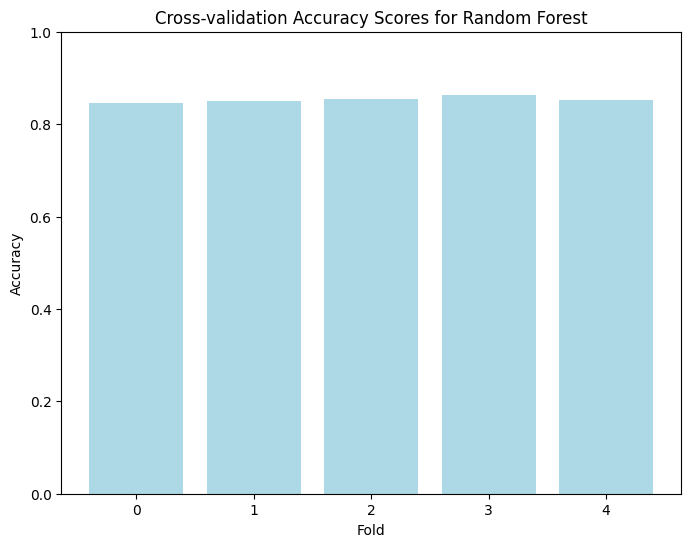

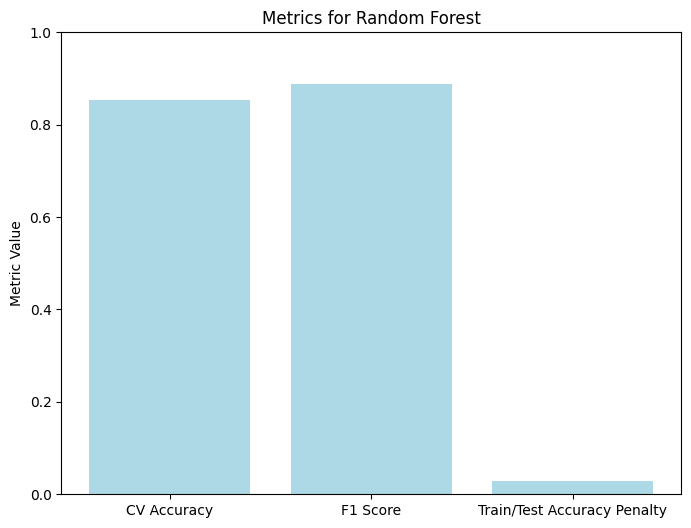


Support Vector Machine Training Accuracy: 0.8406
Support Vector Machine Test Accuracy: 0.8967
Support Vector Machine F1 Score (Test): 0.8980
Support Vector Machine Mean Cross-validation Accuracy: 0.8411 (+/- 0.0190)
Support Vector Machine Cross-validation Accuracy Scores: [0.83863227 0.8319832  0.8439844  0.85808581 0.83288329]
Support Vector Machine Normalized Accuracy Difference: 0.0626
Support Vector Machine Performance Score: 0.8070

Classification Report for Support Vector Machine on Test Data:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2091
           1       0.74      0.80      0.77       580

    accuracy                           0.90      2671
   macro avg       0.84      0.86      0.85      2671
weighted avg       0.90      0.90      0.90      2671



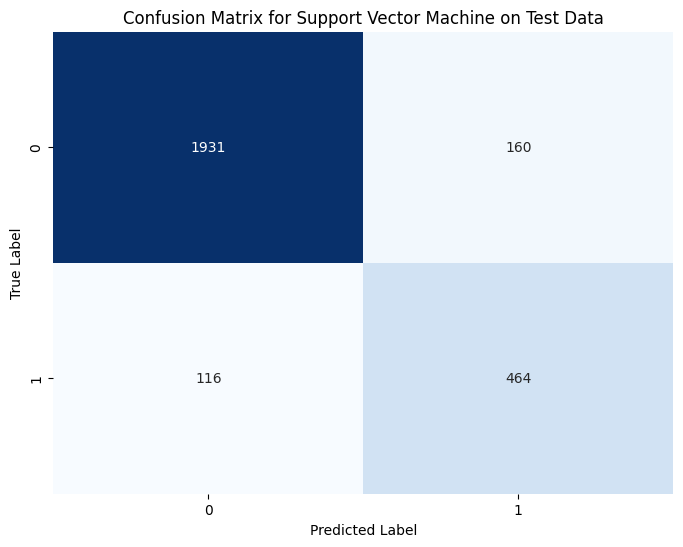

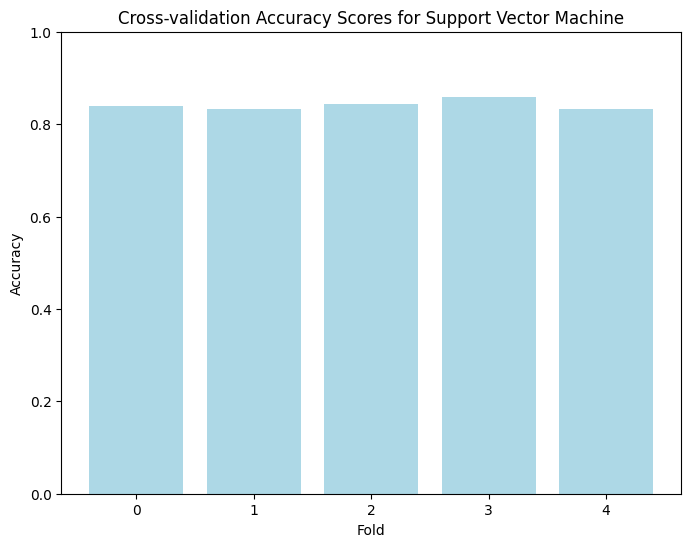

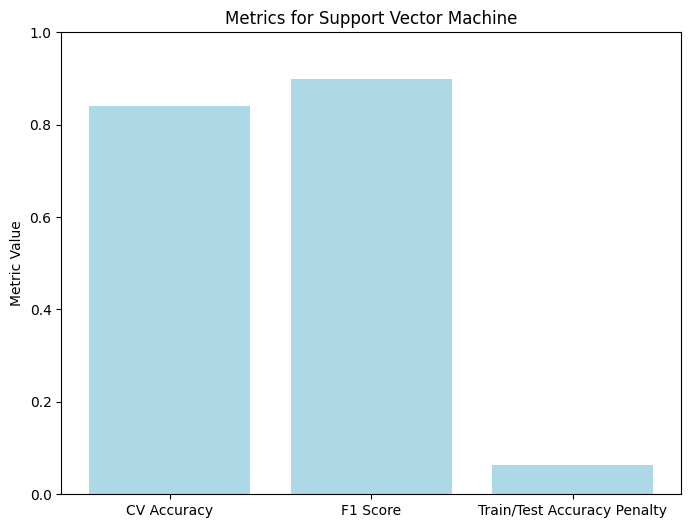


K-Nearest Neighbors Training Accuracy: 0.8292
K-Nearest Neighbors Test Accuracy: 0.9083
K-Nearest Neighbors F1 Score (Test): 0.9064
K-Nearest Neighbors Mean Cross-validation Accuracy: 0.8187 (+/- 0.0306)
K-Nearest Neighbors Cross-validation Accuracy Scores: [0.79124175 0.8229823  0.83228323 0.83258326 0.81428143]
K-Nearest Neighbors Normalized Accuracy Difference: 0.0870
K-Nearest Neighbors Performance Score: 0.7755

Classification Report for K-Nearest Neighbors on Test Data:

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2091
           1       0.82      0.74      0.78       580

    accuracy                           0.91      2671
   macro avg       0.88      0.85      0.86      2671
weighted avg       0.91      0.91      0.91      2671



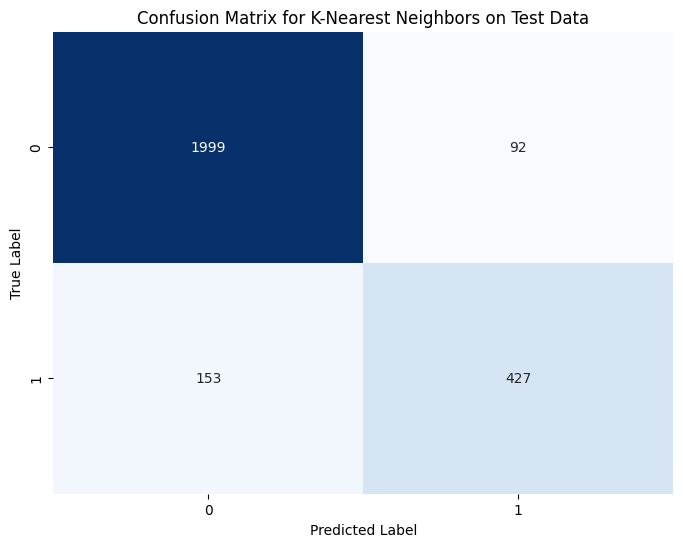

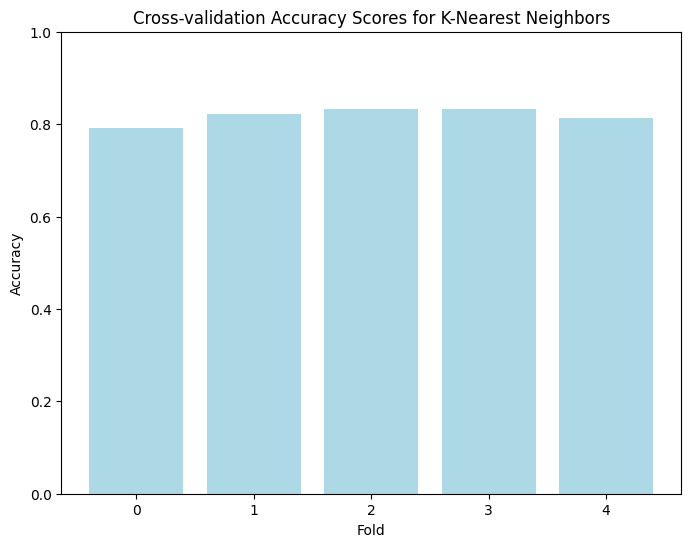

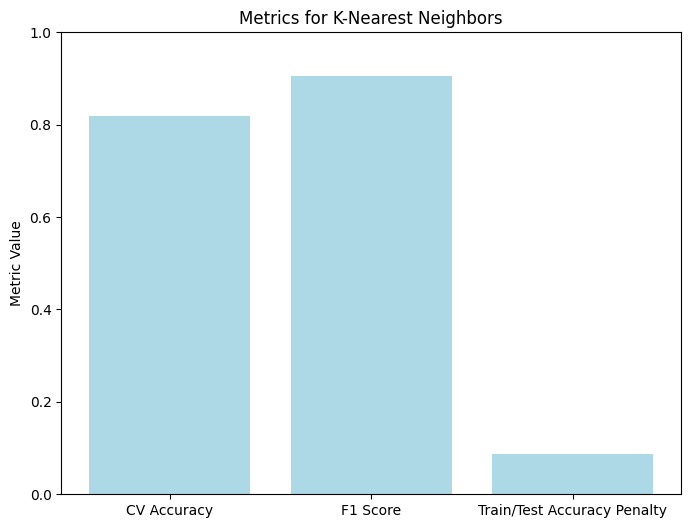


Best Classification Model: Decision Tree with Performance Score: 0.8412


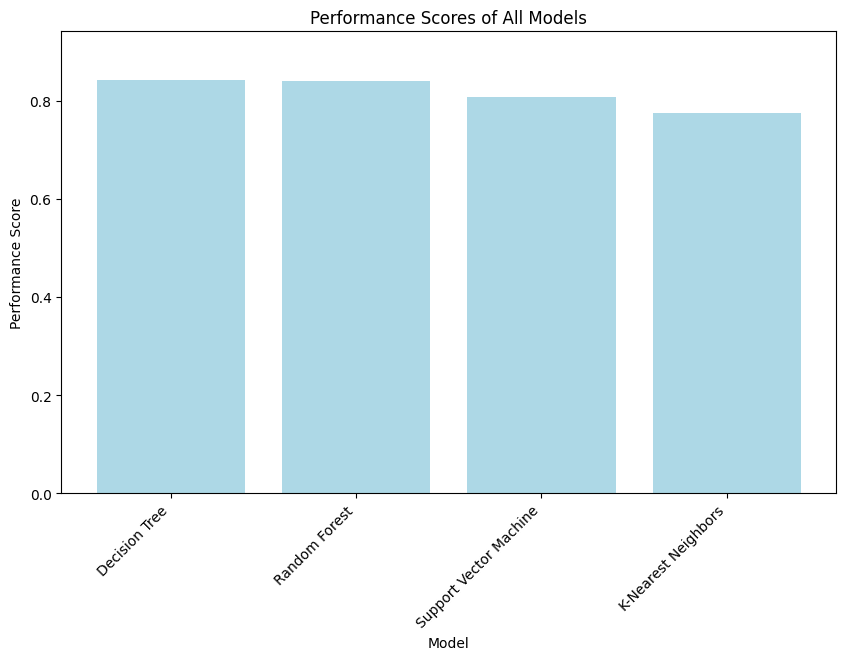

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, learning_curve
import numpy as np

w1_cros_ac, w2_f1, w3_acc_dif = 0.5, 0.5, 1

random_state = 42

best_model = None
best_performance = -float('inf')
best_name = ""
best_predictions = None

performance_scores = {}

classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'Random Forest': RandomForestClassifier(random_state=random_state),
    'Support Vector Machine': SVC(random_state=random_state, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

for name, model in classifiers.items():
    # Train the current model
    model.fit(X_train_clf_resampled, y_train_clf_resampled)

    # Compute predictions on training and test data and save corresponding ...
    # ... accuracies

    y_train_pred = model.predict(X_train_clf_resampled)
    y_test_pred = model.predict(X_test_clf_scaled)

    train_accuracy = accuracy_score(y_train_clf_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test_clf, y_test_pred)

    f1 = f1_score(y_test_clf, y_test_pred, average='weighted', zero_division=1)

    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train_clf_resampled, y_train_clf_resampled, cv=5, scoring='accuracy', n_jobs=-1)
    mean_cv_score = cv_scores.mean()

    # Calculate and store the custom performance metrics
    normalized_accuracy_diff = (abs(train_accuracy - test_accuracy) / max(train_accuracy, test_accuracy))

    performance_score = (w1_cros_ac * mean_cv_score) + (w2_f1 * f1) - (w3_acc_dif * normalized_accuracy_diff)
    performance_scores[name] = performance_score

    # Print model results
    print(f"\n{name} Training Accuracy: {train_accuracy:.4f}")
    print(f"{name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{name} F1 Score (Test): {f1:.4f}")
    print(f"{name} Mean Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"{name} Cross-validation Accuracy Scores: {cv_scores}")
    print(f"{name} Normalized Accuracy Difference: {normalized_accuracy_diff:.4f}")
    print(f"{name} Performance Score: {performance_score:.4f}")

    print(f"\nClassification Report for {name} on Test Data:\n")
    print(classification_report(y_test_clf, y_test_pred, zero_division=1))

    if performance_score > best_performance:
        best_performance = performance_score
        best_model = model
        best_name = name
        best_predictions = y_test_pred

    cm_test = confusion_matrix(y_test_clf, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {name} on Test Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    # Plot cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(cv_scores)), cv_scores, color='lightblue')
    plt.title(f'Cross-validation Accuracy Scores for {name}')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

    metrics = [mean_cv_score, f1, normalized_accuracy_diff]
    metric_names = ['CV Accuracy', 'F1 Score', 'Train/Test Accuracy Penalty']

    plt.figure(figsize=(8, 6))
    plt.bar(metric_names, metrics, color=['lightblue', 'lightblue', 'lightblue'])
    plt.title(f'Metrics for {name}')
    plt.ylabel('Metric Value')
    plt.ylim(0, 1)  # Y-axis from 0 to 1
    plt.show()


print(f"\nBest Classification Model: {best_name} with Performance Score: {best_performance:.4f}")

# Plot performance scores for all models
plt.figure(figsize=(10, 6))
plt.bar(performance_scores.keys(), performance_scores.values(), color='lightblue')
plt.title('Performance Scores of All Models')
plt.xlabel('Model')
plt.ylabel('Performance Score')
plt.ylim(0, max(performance_scores.values()) + 0.1)
plt.xticks(rotation=45, ha='right')
plt.show()